In [1]:
import matplotlib.pyplot as plt
import os
import torch
import torchaudio
from tqdm import tqdm
import csv
import pandas as pd
import sys
import re
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



1. Prepare X(Filename) and Y(Label)

2. EDA

3. Preprocesing data

 3.1 Resize to fixed length

 3.2 Audio Augmentation Time shift

 3.3 Comvert to MFCC

## 1. Prepare label

In [2]:
'''
dirname        : path that need to be searched
ret                : files in the dirname (recursive)
list_avoid_dir : dirname need to be skipped
usage           : 
    list_files = []
    file_search(dirname, list_files):   
'''
def file_search(dirname, ret, list_avoid_dir=[]):
    
    filenames = os.listdir(dirname)
    
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)

        if os.path.isdir(full_filename) :
            if full_filename.split('/')[-1] in list_avoid_dir:
                continue
            else:
                file_search(full_filename, ret, list_avoid_dir)
            
        else:
            ret.append(full_filename)          

            

'''
dir_name : dir_name (inc. path) that will be created ( full-path name )
'''
def create_folder(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

In [3]:
def extract_trans(list_in_file, out_file):
    
    lines = []
    
    for in_file in list_in_file:
        cnt = 0
        
        with open(in_file, 'r') as f1:
            lines = f1.readlines()

        with open(out_file, 'a') as f2:

            csv_writer = csv.writer(f2)
            lines = sorted(lines)                  # sort based on first element
            
            for line in lines:

                name = line.split(':')[0].split(' ')[0].strip()
                
                # unwanted case 
                if name[:3] != 'Ses':             # noise transcription such as reply  M: sorry
                    continue
                elif name[-3:-1] == 'XX':        # we don't have matching pair in label
                    continue
                trans = line.split(':')[1].strip()
                
                cnt += 1
                csv_writer.writerow([name, trans])

In [9]:
# [schema] ID, transcriptions [csv]

list_files = []

for x in range(5):
    sess_name = 'Session' + str(x+1)

    path = './IEMOCAP_full_release/' + sess_name + '/dialog/transcriptions/'
    file_search(path, list_files)
    list_files = sorted(list_files)

    print (sess_name + ", #sum files: " + str(len(list_files)))

extract_trans(list_files, 'processed_trans.csv')

Session1, #sum files: 28
Session2, #sum files: 58
Session3, #sum files: 90
Session4, #sum files: 120
Session5, #sum files: 151


In [10]:
# read contents of csv file
file = pd.read_csv("processed_trans.csv")
  
# adding header
headerList = ['sessionID', 'text']
  
# converting data frame to csv
file.to_csv("processed_trans_head.csv", header=headerList, index=False)

In [11]:
list_category = [
                'ang',
                'hap',
                'sad',
                'neu',
                'fru',
                'exc',
                'fea',
                'sur',
                'dis',
                'oth',
                'xxx'
                ]

category = {}
for c_type in list_category:
    if category.__contains__(c_type):
        pass
    else:
        category[c_type] = len(category)

In [12]:
def find_category(lines):
    is_target = True
    
    id = ''
    c_label = ''
    list_ret = []
    
    for line in lines:
        
        if is_target == True:
            
            try:
                id = line.split('\t')[1].strip()  #  extract ID
                c_label = line.split('\t')[2].strip()  #  extract category
                if not category.__contains__(c_label):
                    c_label = re.sub(r'[^A-Za-z0-9]', '', c_label)
                
                list_ret.append( [id, c_label] )
                is_target = False

            except:
                print("ERROR ", line)
                sys.exit()
        
        else:
            if line == '\n':
                is_target = True
        
    return list_ret

In [13]:
def extract_labels(list_in_file, out_file) :
    id = ''
    lines = []
    list_ret = []
    
    for in_file in list_in_file:
        
        with open(in_file, 'r') as f1:
            lines = f1.readlines()
            lines = lines[2:]                           # remove head
            list_ret = find_category(lines)
            
        list_ret = sorted(list_ret)                   # sort based on first element
    
        with open(out_file, 'a') as f2:
            csv_writer = csv.writer(f2)
            csv_writer.writerows(list_ret)

In [14]:
# [schema] ID, label [csv]

list_files = []
list_avoid_dir = ['Attribute', 'Categorical', 'Self-evaluation']

for x in range(5):
    sess_name = 'Session' + str(x+1)

    path = './IEMOCAP_full_release/' + sess_name + '/dialog/EmoEvaluation/'
    file_search(path, list_files, list_avoid_dir)
    list_files = sorted(list_files)

    print(sess_name + ", #sum files: " + str(len(list_files)))

extract_labels(list_files, "processed_labels.csv")

Session1, #sum files: 28
Session2, #sum files: 58
Session3, #sum files: 90
Session4, #sum files: 120
Session5, #sum files: 151


## 2. EDA

In [15]:
# read contents of csv file
file = pd.read_csv("processed_labels.csv")
  
# adding header
headerList = ['sessionID', 'label']
  
# converting data frame to csv
file.to_csv("processed_labels_head.csv", header=headerList, index=False)

In [19]:
df = pd.read_csv('processed_labels_head.csv')
df.head(10)

,sessionID,label
0,Ses01F_impro01_F001,neu
1,Ses01F_impro01_F002,neu
2,Ses01F_impro01_F003,xxx
3,Ses01F_impro01_F004,xxx
4,Ses01F_impro01_F005,neu
5,Ses01F_impro01_F006,fru
6,Ses01F_impro01_F007,fru
7,Ses01F_impro01_F008,fru
8,Ses01F_impro01_F009,fru
9,Ses01F_impro01_F010,xxx


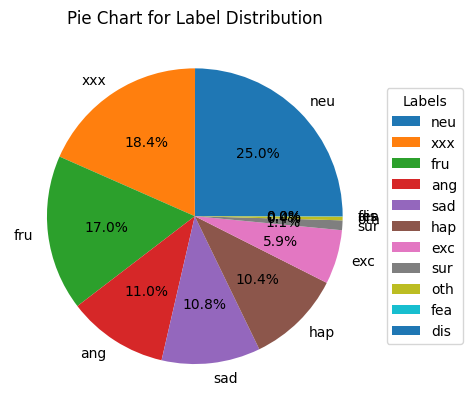

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have already read the CSV file into a DataFrame named 'df'

# Get unique labels
labels = df['label'].unique()

# Calculate percentage
percentage = df['label'].value_counts(normalize=True) * 100

# Convert percentage Series to list
percentage_list = percentage.tolist()

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(percentage, labels=labels,autopct='%1.1f%%')
ax.legend(title ="Labels",
          loc ="center left",
          bbox_to_anchor =(1, 0, 0.5, 1))
plt.title('Pie Chart for Label Distribution')
#plt.setp(autotexts, size = 8, weight ="bold")
plt.show()


In [46]:
dfl = pd.read_csv('processed_labels_head.csv')
df_encode = pd.get_dummies(dfl,columns=['label'])
df_encode.to_csv("processed_onehot_encoding.csv", index = False)

## 3. Preprocesing data

### 3.1 Resize to fixed length

In [ ]:
def sorf_max_length(wav_dir):
    list_files = []
    file_search(wav_dir, list_files)
    list_files = [_ for _ in list_files if _.endswith('.wav')] # Just read file end with .wav
    create_folder(mfcc_dir)


    for wav_file in tqdm(list_files):

        waveform, sample_rate = torchaudio.load(wav_file)

        mfccs = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)
    

def resize_length():
    
    pass

### 3.2 Audio Augmentation Time shift

 ### 3.3 Comvert to MFCC

In [8]:
def convert_wav_to_mfcc(sess_name, wav_dir, mfcc_dir):
  """
  Convert wav files to mfcc and save to mfcc directory
  
  Args:
    sess_name (str): Session name
    wav_dir (str): Directory contains original .wav files  
    mfcc_dir (str): Destination directory to save .pt files
        
  Returns:
    None
  """

  
  list_files = []
  file_search(wav_dir, list_files)
  list_files = [_ for _ in list_files if _.endswith('.wav')] # Just read file end with .wav
  create_folder(mfcc_dir)


  for wav_file in tqdm(list_files):

    waveform, sample_rate = torchaudio.load(wav_file)

    mfccs = torchaudio.transforms.MFCC(sample_rate=sample_rate)(waveform)

    file_name = os.path.basename(wav_file).rsplit('.', 1)[0] + '.pt'
    torch.save(mfccs, os.path.join(mfcc_dir, file_name))

  print(sess_name + ", Done!")

1. Still have some strange files (such as .pk, .DS_store,..) -> need to solve

In [9]:
if __name__ == '__main__':
  for x in range(5):
    sess_name = 'Session' + str(x+1)
    wav_dir = './IEMOCAP_full_release/'+ sess_name + '/sentences/wav/'
    mfcc_dir = './IEMOCAP_full_release/'+ sess_name + '/sentences/wav_mfcc/'

    convert_wav_to_mfcc(sess_name, wav_dir, mfcc_dir)

  0%|          | 0/1819 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(
100%|██████████| 1819/1819 [00:03<00:00, 473.02it/s]


Session1, Done!


100%|██████████| 1811/1811 [00:03<00:00, 491.32it/s]


Session2, Done!


100%|██████████| 2136/2136 [00:04<00:00, 499.22it/s]


Session3, Done!


100%|██████████| 2103/2103 [00:04<00:00, 490.64it/s]


Session4, Done!


100%|██████████| 2170/2170 [00:04<00:00, 477.22it/s]

Session5, Done!


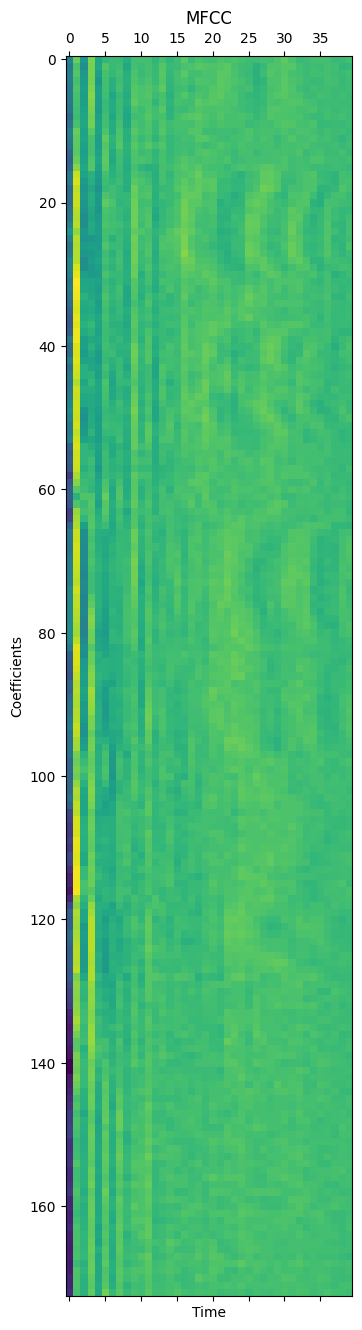

In [11]:
mfccs = torch.load('./IEMOCAP_full_release/Session1/sentences/wav_mfcc/Ses01M_script03_2_M039.pt')
mfccs = mfccs.numpy() 

plt.matshow(mfccs.T)
plt.title('MFCC')
plt.ylabel('Coefficients') 
plt.xlabel('Time')
plt.show()

In [12]:
mfccs.shape

(1, 40, 173)